# 2.0 Execution Analysis

**Purpose:** Analyze actual paper trading execution data to derive realistic estimates for:
- Entry/exit slippage
- Implied move multiplier (market pricing vs historical moves)
- Bid-ask spread costs
- Fill rates and timing
- Model calibration (predicted vs realized moves)

These metrics will inform realistic backtest assumptions in notebooks 1.2 and 1.3.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

DB_PATH = Path('../data/earnings_trades.db')

## 1. Load Trade Data

In [2]:
conn = sqlite3.connect(DB_PATH)

# Load all trades
trades = pd.read_sql_query("""
    SELECT * FROM trades 
    ORDER BY entry_datetime DESC
""", conn)

# Load non-trades for counterfactual comparison
non_trades = pd.read_sql_query("""
    SELECT * FROM non_trades 
    ORDER BY log_datetime DESC
""", conn)

print(f"Total trades: {len(trades)}")
print(f"\nTrade status breakdown:")
print(trades['status'].value_counts())
print(f"\nNon-trades: {len(non_trades)}")

Total trades: 19

Trade status breakdown:
status
exited       12
filled        4
exiting       2
cancelled     1
Name: count, dtype: int64

Non-trades: 104


In [3]:
# Filter to exited trades only for P&L analysis
exited = trades[trades['status'] == 'exited'].copy()
print(f"Exited trades for analysis: {len(exited)}")

# Show key columns
display_cols = ['ticker', 'earnings_date', 'earnings_timing', 'implied_move', 
                'realized_move_pct', 'entry_quoted_mid', 'entry_fill_price',
                'entry_slippage', 'exit_pnl', 'exit_pnl_pct']
exited[display_cols]

Exited trades for analysis: 12


,ticker,earnings_date,earnings_timing,implied_move,realized_move_pct,entry_quoted_mid,entry_fill_price,entry_slippage,exit_pnl,exit_pnl_pct
4,AEHR,2026-01-08,AMC,0.191372,None,4.325,4.250000,-0.180,-262.50,-0.123500
7,HELE,2026-01-08,BMO,0.183629,None,3.825,3.954000,-0.006,-902.00,-0.456247
9,APLD,2026-01-07,AMC,0.144536,None,4.305,4.330000,0.000,-850.00,-0.392610
10,JEF,2026-01-07,AMC,0.072475,None,4.700,4.700000,-0.180,-350.00,-0.148936
11,STZ,2026-01-07,AMC,0.055210,None,7.800,7.800000,-0.180,-1050.00,-0.269231
12,HELE,2026-01-08,BMO,0.184426,None,3.825,3.900000,0.000,-875.00,-0.448718
13,AYI,2026-01-08,BMO,0.076120,None,28.300,27.950000,-1.610,9925.00,0.710197
14,APLD,2026-01-07,AMC,0.148161,None,4.430,4.400000,-0.110,-885.00,-0.402273
15,JEF,2026-01-07,AMC,0.071494,None,4.650,4.700000,-0.100,-350.00,-0.148936
16,STZ,2026-01-07,AMC,0.055634,None,7.850,7.800000,-0.140,-1050.00,-0.269231


## 2. Entry Slippage Analysis

Slippage = Fill Price - Quoted Mid (positive = paid more than mid)

In [4]:
# Calculate entry slippage where we have the data
entry_analysis = trades[trades['entry_fill_price'].notna()].copy()

# Compute slippage if not already stored
entry_analysis['calc_entry_slippage'] = entry_analysis['entry_fill_price'] - entry_analysis['entry_quoted_mid']
entry_analysis['entry_slippage_pct'] = entry_analysis['calc_entry_slippage'] / entry_analysis['entry_quoted_mid'] * 100

# Entry spread (if available)
entry_analysis['entry_spread'] = entry_analysis['entry_quoted_ask'] - entry_analysis['entry_quoted_bid']
entry_analysis['entry_spread_pct'] = entry_analysis['entry_spread'] / entry_analysis['entry_quoted_mid'] * 100

print("=== ENTRY SLIPPAGE STATISTICS ===")
print(f"\nSample size: {len(entry_analysis)} trades with entry fills")
print(f"\nSlippage ($ per straddle):")
print(entry_analysis['calc_entry_slippage'].describe())
print(f"\nSlippage (% of mid):")
print(entry_analysis['entry_slippage_pct'].describe())

=== ENTRY SLIPPAGE STATISTICS ===

Sample size: 18 trades with entry fills

Slippage ($ per straddle):
count    18.000000
mean      0.038474
std       0.195323
min      -0.350000
25%      -0.022500
50%       0.027500
75%       0.055231
max       0.710000
Name: calc_entry_slippage, dtype: float64

Slippage (% of mid):
count    18.000000
mean      0.643900
std       1.558049
min      -1.734104
25%      -0.477707
50%       0.608157
75%       1.058553
max       4.437500
Name: entry_slippage_pct, dtype: float64


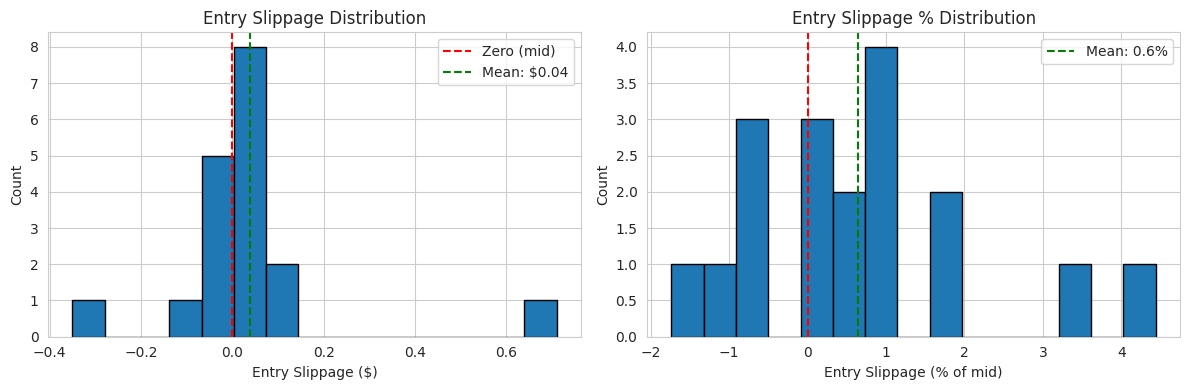

In [5]:
# Visualize entry slippage
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if len(entry_analysis) > 0:
    axes[0].hist(entry_analysis['calc_entry_slippage'].dropna(), bins=15, edgecolor='black')
    axes[0].axvline(0, color='red', linestyle='--', label='Zero (mid)')
    axes[0].axvline(entry_analysis['calc_entry_slippage'].mean(), color='green', linestyle='--', 
                    label=f"Mean: ${entry_analysis['calc_entry_slippage'].mean():.2f}")
    axes[0].set_xlabel('Entry Slippage ($)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Entry Slippage Distribution')
    axes[0].legend()

    axes[1].hist(entry_analysis['entry_slippage_pct'].dropna(), bins=15, edgecolor='black')
    axes[1].axvline(0, color='red', linestyle='--')
    axes[1].axvline(entry_analysis['entry_slippage_pct'].mean(), color='green', linestyle='--',
                    label=f"Mean: {entry_analysis['entry_slippage_pct'].mean():.1f}%")
    axes[1].set_xlabel('Entry Slippage (% of mid)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Entry Slippage % Distribution')
    axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Bid-Ask Spread Analysis

In [6]:
print("=== BID-ASK SPREAD STATISTICS ===")
print(f"\nEntry spread ($):")
print(entry_analysis['entry_spread'].describe())
print(f"\nEntry spread (%):")
print(entry_analysis['entry_spread_pct'].describe())

# Compare to our screening threshold
SPREAD_THRESHOLD = 15.0  # From .env
print(f"\n--- Screening threshold: {SPREAD_THRESHOLD}% ---")
print(f"Trades within threshold: {(entry_analysis['entry_spread_pct'] <= SPREAD_THRESHOLD).sum()} / {len(entry_analysis)}")

=== BID-ASK SPREAD STATISTICS ===

Entry spread ($):
count    18.000000
mean      0.668333
std       1.017033
min       0.090000
25%       0.265000
50%       0.325000
75%       0.500000
max       4.200000
Name: entry_spread, dtype: float64

Entry spread (%):
count    18.000000
mean      8.255655
std       4.442597
min       2.090592
25%       5.206744
50%       7.114128
75%      11.511701
max      16.216216
Name: entry_spread_pct, dtype: float64

--- Screening threshold: 15.0% ---
Trades within threshold: 17 / 18


In [7]:
# Per-trade spread details
spread_cols = ['ticker', 'earnings_date', 'entry_quoted_bid', 'entry_quoted_ask', 
               'entry_quoted_mid', 'entry_spread', 'entry_spread_pct', 'entry_fill_price']
entry_analysis[spread_cols].sort_values('entry_spread_pct', ascending=False)

,ticker,earnings_date,entry_quoted_bid,entry_quoted_ask,entry_quoted_mid,entry_spread,entry_spread_pct,entry_fill_price
8,NEOG,2026-01-08,0.85,1.00,0.925,0.15,16.216216,0.932000
6,WDFC,2026-01-08,14.80,17.20,16.000,2.40,15.000000,16.710000
13,AYI,2026-01-08,26.20,30.40,28.300,4.20,14.840989,27.950000
10,JEF,2026-01-07,4.40,5.00,4.700,0.60,12.765957,4.700000
7,HELE,2026-01-08,3.60,4.05,3.825,0.45,11.764706,3.954000
15,JEF,2026-01-07,4.40,4.90,4.650,0.50,10.752688,4.700000
18,PENG,2026-01-06,3.75,4.15,3.950,0.40,10.126582,4.022055
4,AEHR,2026-01-08,4.15,4.50,4.325,0.35,8.092486,4.250000
11,STZ,2026-01-07,7.50,8.10,7.800,0.60,7.692308,7.800000
12,HELE,2026-01-08,3.70,3.95,3.825,0.25,6.535948,3.900000


## 4. Implied Move Multiplier Analysis

Key question: How much premium does the options market charge over historical moves?

Multiplier = Implied Move / Historical Move Mean

In [8]:
# We need to compare implied_move to the model's hist_move_mean
# The predicted_q50 approximates hist_move_mean for well-calibrated model

# For trades where we have both implied_move and predicted values
move_analysis = exited[exited['implied_move'].notna() & exited['predicted_q50'].notna()].copy()

if len(move_analysis) > 0:
    # Calculate multiplier: implied / predicted median (which tracks historical)
    move_analysis['implied_multiplier'] = move_analysis['implied_move'] / move_analysis['predicted_q50']
    
    print("=== IMPLIED MOVE MULTIPLIER ===")
    print(f"\nSample size: {len(move_analysis)} trades")
    print(f"\nImplied Move / Predicted Q50:")
    print(move_analysis['implied_multiplier'].describe())
    print(f"\nMean multiplier: {move_analysis['implied_multiplier'].mean():.2f}x")
    print(f"Median multiplier: {move_analysis['implied_multiplier'].median():.2f}x")
else:
    print("Not enough trades with both implied_move and predicted_q50 to calculate multiplier")

Not enough trades with both implied_move and predicted_q50 to calculate multiplier


In [9]:
# Alternative: Use non-trades which may have more data
# Non-trades have implied_move from screening
nt_with_implied = non_trades[non_trades['implied_move'].notna()].copy()

print(f"\n=== NON-TRADES IMPLIED MOVE DATA ===")
print(f"Non-trades with implied_move: {len(nt_with_implied)}")
print(f"\nImplied move distribution:")
print(nt_with_implied['implied_move'].describe())


=== NON-TRADES IMPLIED MOVE DATA ===
Non-trades with implied_move: 48

Implied move distribution:
count    48.000000
mean      0.093792
std       0.031046
min       0.044823
25%       0.063511
50%       0.093370
75%       0.115534
max       0.183597
Name: implied_move, dtype: float64


In [10]:
# Compare implied vs realized for exited trades
realized_analysis = exited[exited['implied_move'].notna() & exited['realized_move_pct'].notna()].copy()

if len(realized_analysis) > 0:
    print("=== IMPLIED vs REALIZED MOVE ===")
    print(f"\nSample size: {len(realized_analysis)} trades")
    
    # Note: realized_move_pct is already absolute (unsigned)
    realized_analysis['realized_abs'] = realized_analysis['realized_move_pct'].abs()
    realized_analysis['implied_vs_realized'] = realized_analysis['implied_move'] / realized_analysis['realized_abs']
    
    print(f"\nImplied Move (what we paid for):")
    print(realized_analysis['implied_move'].describe())
    print(f"\nRealized Move (what happened):")
    print(realized_analysis['realized_abs'].describe())
    
    # Did realized exceed implied?
    realized_analysis['beat_implied'] = realized_analysis['realized_abs'] > realized_analysis['implied_move']
    print(f"\nRealized > Implied: {realized_analysis['beat_implied'].sum()} / {len(realized_analysis)} ({realized_analysis['beat_implied'].mean()*100:.0f}%)")
else:
    print("Not enough exited trades with realized move data")

Not enough exited trades with realized move data


In [11]:
# Detailed per-trade comparison
if len(realized_analysis) > 0:
    detail_cols = ['ticker', 'earnings_date', 'implied_move', 'realized_abs', 
                   'beat_implied', 'exit_pnl', 'exit_pnl_pct']
    display(realized_analysis[detail_cols].sort_values('earnings_date'))

## 5. Exit Slippage Analysis

In [12]:
# Analyze exit execution
exit_analysis = exited[exited['exit_fill_price'].notna() & exited['exit_quoted_mid'].notna()].copy()

if len(exit_analysis) > 0:
    exit_analysis['calc_exit_slippage'] = exit_analysis['exit_fill_price'] - exit_analysis['exit_quoted_mid']
    exit_analysis['exit_slippage_pct'] = exit_analysis['calc_exit_slippage'] / exit_analysis['exit_quoted_mid'] * 100
    
    print("=== EXIT SLIPPAGE STATISTICS ===")
    print(f"\nSample size: {len(exit_analysis)} trades with exit fills")
    print(f"\nExit slippage ($):")
    print(exit_analysis['calc_exit_slippage'].describe())
    print(f"\nExit slippage (%):")
    print(exit_analysis['exit_slippage_pct'].describe())
else:
    print("Not enough exit data with quotes")

=== EXIT SLIPPAGE STATISTICS ===

Sample size: 10 trades with exit fills

Exit slippage ($):
count    1.000000e+01
mean    -6.760000e-01
std      7.439004e-01
min     -2.475000e+00
25%     -9.687500e-01
50%     -5.000000e-01
75%     -1.400000e-01
max     -4.440892e-16
Name: calc_exit_slippage, dtype: float64

Exit slippage (%):
count    1.000000e+01
mean    -9.619734e+00
std      6.091590e+00
min     -1.555556e+01
25%     -1.534392e+01
50%     -1.134021e+01
75%     -3.845410e+00
max     -1.192186e-14
Name: exit_slippage_pct, dtype: float64


## 6. P&L Analysis

In [13]:
print("=== P&L SUMMARY ===")
print(f"\nTotal exited trades: {len(exited)}")

pnl_data = exited[exited['exit_pnl'].notna()].copy()

if len(pnl_data) > 0:
    print(f"\nP&L ($):")
    print(pnl_data['exit_pnl'].describe())
    print(f"\nTotal P&L: ${pnl_data['exit_pnl'].sum():,.2f}")
    print(f"\nP&L (%):")
    print(pnl_data['exit_pnl_pct'].describe())
    
    # Win rate
    winners = (pnl_data['exit_pnl'] > 0).sum()
    losers = (pnl_data['exit_pnl'] <= 0).sum()
    print(f"\nWin rate: {winners}/{len(pnl_data)} ({winners/len(pnl_data)*100:.0f}%)")
    print(f"Avg winner: ${pnl_data[pnl_data['exit_pnl'] > 0]['exit_pnl'].mean():,.2f}")
    print(f"Avg loser: ${pnl_data[pnl_data['exit_pnl'] <= 0]['exit_pnl'].mean():,.2f}")
else:
    print("No P&L data available")

=== P&L SUMMARY ===

Total exited trades: 12

P&L ($):
count      12.000000
mean      177.697500
std      3092.315417
min     -1206.590000
25%      -939.000000
50%      -862.500000
75%      -328.125000
max      9925.000000
Name: exit_pnl, dtype: float64

Total P&L: $2,132.37

P&L (%):
count    12.000000
mean     -0.198172
std       0.322209
min      -0.456247
25%      -0.407416
50%      -0.269231
75%      -0.142577
max       0.710197
Name: exit_pnl_pct, dtype: float64

Win rate: 1/12 (8%)
Avg winner: $9,925.00
Avg loser: $-708.42


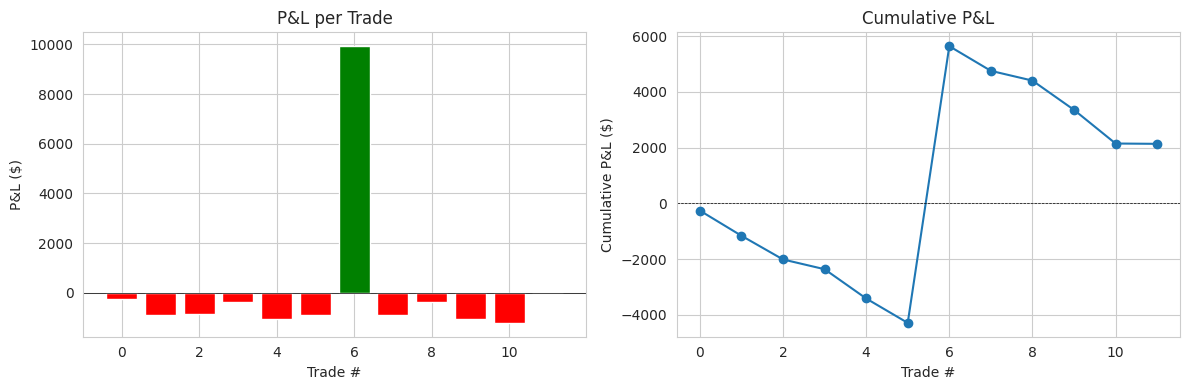

In [14]:
# P&L distribution
if len(pnl_data) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    colors = ['green' if x > 0 else 'red' for x in pnl_data['exit_pnl']]
    axes[0].bar(range(len(pnl_data)), pnl_data['exit_pnl'], color=colors)
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[0].set_xlabel('Trade #')
    axes[0].set_ylabel('P&L ($)')
    axes[0].set_title('P&L per Trade')
    
    # Cumulative P&L
    cum_pnl = pnl_data['exit_pnl'].cumsum()
    axes[1].plot(cum_pnl.values, marker='o')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=0.5)
    axes[1].set_xlabel('Trade #')
    axes[1].set_ylabel('Cumulative P&L ($)')
    axes[1].set_title('Cumulative P&L')
    
    plt.tight_layout()
    plt.show()

## 7. Model Calibration Check

In [15]:
# Check if predicted quantiles are calibrated
calib_data = exited[
    exited['predicted_q50'].notna() & 
    exited['predicted_q75'].notna() &
    exited['predicted_q90'].notna() &
    exited['realized_move_pct'].notna()
].copy()

if len(calib_data) >= 5:
    calib_data['realized_abs'] = calib_data['realized_move_pct'].abs()
    
    # Check exceedance rates
    q50_exceeded = (calib_data['realized_abs'] > calib_data['predicted_q50']).mean()
    q75_exceeded = (calib_data['realized_abs'] > calib_data['predicted_q75']).mean()
    q90_exceeded = (calib_data['realized_abs'] > calib_data['predicted_q90']).mean()
    
    print("=== MODEL CALIBRATION CHECK ===")
    print(f"\nSample size: {len(calib_data)} trades")
    print(f"\nExpected vs Actual Exceedance Rates:")
    print(f"  Q50: Expected 50%, Actual {q50_exceeded*100:.0f}%")
    print(f"  Q75: Expected 25%, Actual {q75_exceeded*100:.0f}%")
    print(f"  Q90: Expected 10%, Actual {q90_exceeded*100:.0f}%")
    
    # Note: Small sample caveat
    print(f"\n⚠️  Small sample size - calibration estimates have high variance")
else:
    print(f"Only {len(calib_data)} trades with calibration data - need more trades")

Only 0 trades with calibration data - need more trades


## 8. Fill Timing Analysis

In [16]:
# Analyze fill latency
timing_data = trades[trades['fill_latency_seconds'].notna()].copy()

if len(timing_data) > 0:
    print("=== FILL TIMING ===")
    print(f"\nSample size: {len(timing_data)} trades with timing data")
    print(f"\nFill latency (seconds):")
    print(timing_data['fill_latency_seconds'].describe())
    
    # Convert to minutes for readability
    timing_data['fill_latency_minutes'] = timing_data['fill_latency_seconds'] / 60
    print(f"\nFill latency (minutes):")
    print(timing_data['fill_latency_minutes'].describe())
else:
    print("No fill timing data available")

No fill timing data available


## 9. Counterfactual Analysis (Non-Trades)

In [17]:
# Analyze what we missed by not trading
cf_data = non_trades[
    non_trades['counterfactual_realized_move'].notna() & 
    non_trades['counterfactual_pnl'].notna()
].copy()

if len(cf_data) > 0:
    print("=== COUNTERFACTUAL ANALYSIS (What We Missed) ===")
    print(f"\nNon-trades with counterfactual data: {len(cf_data)}")
    
    # Rejection reasons
    print(f"\nRejection reasons:")
    print(cf_data['rejection_reason'].value_counts().head(10))
    
    # P&L we would have made
    print(f"\nCounterfactual P&L (if we had traded):")
    print(cf_data['counterfactual_pnl'].describe())
    print(f"\nTotal missed P&L: ${cf_data['counterfactual_pnl'].sum():,.2f}")
    
    # Would-be winners vs losers
    cf_winners = (cf_data['counterfactual_pnl'] > 0).sum()
    print(f"Would-be win rate: {cf_winners}/{len(cf_data)} ({cf_winners/len(cf_data)*100:.0f}%)")
else:
    print("No counterfactual data available")

=== COUNTERFACTUAL ANALYSIS (What We Missed) ===

Non-trades with counterfactual data: 48

Rejection reasons:
rejection_reason
No ML data                        7
Spread too wide: 32.1% > 20.0%    3
Spread too wide: 31.2% > 20.0%    3
Spread too wide: 24.3% > 20.0%    3
Spread too wide: 56.4% > 20.0%    2
Spread too wide: 27.2% > 20.0%    2
Spread too wide: 55.3% > 20.0%    2
Spread too wide: 36.3% > 20.0%    2
Spread too wide: 28.6% > 20.0%    1
Spread too wide: 53.3% > 20.0%    1
Name: count, dtype: int64

Counterfactual P&L (if we had traded):
count    48.000000
mean     -2.084111
std       4.953600
min     -14.245762
25%      -3.070155
50%      -0.895523
75%      -0.310337
max      19.908149
Name: counterfactual_pnl, dtype: float64

Total missed P&L: $-100.04
Would-be win rate: 11/48 (23%)


In [18]:
# Breakdown by rejection reason
if len(cf_data) > 0:
    cf_by_reason = cf_data.groupby('rejection_reason').agg({
        'counterfactual_pnl': ['count', 'sum', 'mean'],
        'counterfactual_realized_move': 'mean'
    }).round(2)
    cf_by_reason.columns = ['Count', 'Total P&L', 'Avg P&L', 'Avg Move']
    cf_by_reason = cf_by_reason.sort_values('Count', ascending=False)
    print("\nCounterfactual by rejection reason:")
    display(cf_by_reason)


Counterfactual by rejection reason:


,Count,Total P&L,Avg P&L,Avg Move
rejection_reason,,,,
No ML data,7,-27.92,-3.99,0.04
Spread too wide: 24.3% > 20.0%,3,2.62,0.87,0.14
Spread too wide: 32.1% > 20.0%,3,-1.41,-0.47,0.09
Spread too wide: 31.2% > 20.0%,3,-2.68,-0.89,0.10
Spread too wide: 55.3% > 20.0%,2,-2.67,-1.33,0.07
Spread too wide: 36.3% > 20.0%,2,0.48,0.24,0.07
Spread too wide: 27.2% > 20.0%,2,-2.09,-1.04,0.06
Spread too wide: 56.4% > 20.0%,2,-0.62,-0.31,0.10
Spread too wide: 54.5% > 20.0%,1,-2.89,-2.89,0.02


## 10. Summary: Recommended Backtest Parameters

In [19]:
print("="*60)
print("RECOMMENDED BACKTEST PARAMETERS")
print("="*60)

# Entry slippage
if len(entry_analysis) > 0 and entry_analysis['entry_slippage_pct'].notna().any():
    entry_slip = entry_analysis['entry_slippage_pct'].mean()
    print(f"\n1. Entry Slippage: {entry_slip:.1f}% of mid")
else:
    print(f"\n1. Entry Slippage: Insufficient data (use 1-2% estimate)")

# Spread cost
if len(entry_analysis) > 0 and entry_analysis['entry_spread_pct'].notna().any():
    spread = entry_analysis['entry_spread_pct'].mean()
    print(f"\n2. Average Spread: {spread:.1f}%")
    print(f"   Half-spread cost: {spread/2:.1f}%")
else:
    print(f"\n2. Spread Cost: Insufficient data (use 3-5% half-spread)")

# Implied move multiplier
if 'move_analysis' in dir() and len(move_analysis) > 0:
    mult = move_analysis['implied_multiplier'].median()
    print(f"\n3. Implied Move Multiplier: {mult:.2f}x")
else:
    print(f"\n3. Implied Move Multiplier: Insufficient data (use 1.3x default)")

# Commission
print(f"\n4. Commission: $1.30/contract (IBKR standard)")
print(f"   Per straddle (2 legs): $2.60")

# Fill rate estimate
filled = len(trades[trades['status'].isin(['filled', 'exited'])])
total_attempts = len(trades)
if total_attempts > 0:
    fill_rate = filled / total_attempts
    print(f"\n5. Fill Rate: {fill_rate*100:.0f}% ({filled}/{total_attempts})")

print("\n" + "="*60)
print("NOTE: These estimates have high variance due to small sample size.")
print("Collect 30+ trades before making definitive conclusions.")
print("="*60)

RECOMMENDED BACKTEST PARAMETERS

1. Entry Slippage: 0.6% of mid

2. Average Spread: 8.3%
   Half-spread cost: 4.1%

3. Implied Move Multiplier: Insufficient data (use 1.3x default)

4. Commission: $1.30/contract (IBKR standard)
   Per straddle (2 legs): $2.60

5. Fill Rate: 84% (16/19)

NOTE: These estimates have high variance due to small sample size.
Collect 30+ trades before making definitive conclusions.


In [20]:
# Per-trade detail table for reference
detail_cols = ['ticker', 'earnings_date', 'earnings_timing', 'status',
               'implied_move', 'realized_move_pct', 'entry_fill_price', 
               'exit_pnl', 'exit_pnl_pct', 'contracts']
available_cols = [c for c in detail_cols if c in trades.columns]
trades[available_cols].sort_values('earnings_date', ascending=False)

,ticker,earnings_date,earnings_timing,status,implied_move,realized_move_pct,entry_fill_price,exit_pnl,exit_pnl_pct,contracts
0,CNXC,2026-01-13,BMO,filled,0.142998,None,5.850000,NaN,NaN,3
2,BK,2026-01-13,BMO,filled,0.035229,None,4.162500,NaN,NaN,4
3,JPM,2026-01-13,BMO,filled,0.036562,None,11.830000,NaN,NaN,1
1,DAL,2026-01-13,BMO,filled,0.066516,None,4.750000,NaN,NaN,4
4,AEHR,2026-01-08,AMC,exited,0.191372,None,4.250000,-262.50,-0.123500,5
5,TLRY,2026-01-08,AMC,cancelled,0.111597,None,NaN,NaN,NaN,5
6,WDFC,2026-01-08,AMC,exiting,0.078643,None,16.710000,-5605.00,-0.670856,5
7,HELE,2026-01-08,BMO,exited,0.183629,None,3.954000,-902.00,-0.456247,5
8,NEOG,2026-01-08,BMO,exiting,0.126712,None,0.932000,NaN,NaN,5
12,HELE,2026-01-08,BMO,exited,0.184426,None,3.900000,-875.00,-0.448718,5


In [ ]:
conn.close()